In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.distilbert_conf
encoding_type = 'pos'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_pos_about'

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.573816458834173 	 Validation loss: 0.4212301772529796 	 
  1%|          | 574/57400 [02:16<4:32:52,  3.47it/s]
Epoch 2 	 Training loss: 0.38971932279108296 	 Validation loss: 0.358145198832124 	 
  2%|▏         | 1148/57400 [05:11<4:21:17,  3.59it/s]
Epoch 3 	 Training loss: 0.3517772209301643 	 Validation loss: 0.3413672952328698 	 
  3%|▎         | 1722/57400 [08:35<3:37:10,  4.27it/s]
Epoch 4 	 Training loss: 0.33303848744892495 	 Validation loss: 0.33082459791231966 	 
  4%|▍         | 2296/57400 [11:24<3:36:21,  4.24it/s]
Epoch 5 	 Training loss: 0.31861384267487175 	 Validation loss: 0.3244918019084607 	 
  5%|▌         | 2870/57400 [14:12<4:19:38,  3.50it/s]
Epoch 6 	 Training loss: 0.3084560206698624 	 Validation loss: 0.3182255049883309 	 
  6%|▌         | 3444/57400 [17:03<4:30:58,  3.32it/s]
Epoch 7 	 Training loss: 0.299303707163716 	 Validation loss: 0.3144021190829196 	 
  7%|▋         | 4018/57400 [20:05<4:06:29,  3.61it/s]
Epoch 8 	 Training l

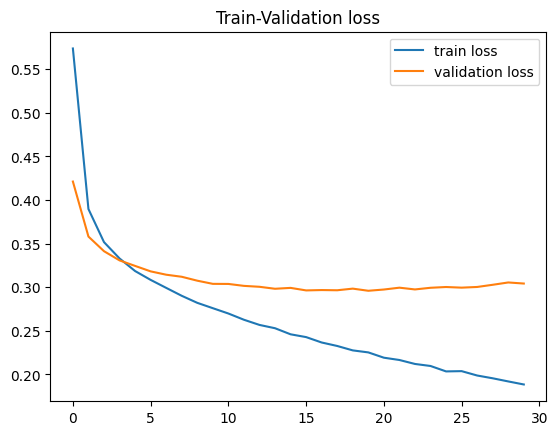

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [16]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('distilbert_pos_about'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8380102040816326, 'precision': 0.8380102040816326, 'f1': 0.8380102040816326, 'accuracy': 0.8380102040816326}
MALE {'recall': 0.8489583333333334, 'precision': 0.8489583333333334, 'f1': 0.8489583333333334, 'accuracy': 0.8489583333333334}
FEMALE {'recall': 0.8275, 'precision': 0.8275, 'f1': 0.8275, 'accuracy': 0.8275} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6679292929292929, 'precision': 0.6679292929292929, 'f1': 0.6679292929292929, 'accuracy': 0.6679292929292929}
MALE {'recall': 0.683698296836983, 'precision': 0.683698296836983, 'f1': 0.683698296836983, 'accuracy': 0.683698296836983}
FEMALE {'recall': 0.6509186351706037, 'precision': 0.6509186351706037, 'f1': 0.6509186351706037, 'accuracy': 0.6509186351706037} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6779661016949152, 'precision': 0.6779661016949152, 'f1': 0.6779661016949152, 'accuracy': 0.6779661016949152}
MALE {'recall': 0.66

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5603720672454569 	 Validation loss: 0.41854937248310803 	 
  1%|          | 574/57400 [02:44<4:18:32,  3.66it/s]
Epoch 2 	 Training loss: 0.3872002111390908 	 Validation loss: 0.3565910594948268 	 
  2%|▏         | 1148/57400 [05:35<6:13:58,  2.51it/s]
Epoch 3 	 Training loss: 0.34960066470015755 	 Validation loss: 0.3401486355874498 	 
  3%|▎         | 1722/57400 [09:04<5:43:02,  2.71it/s]
Epoch 4 	 Training loss: 0.3329047159606571 	 Validation loss: 0.3314904179108345 	 
  4%|▍         | 2296/57400 [12:39<4:20:16,  3.53it/s]
Epoch 5 	 Training loss: 0.3188466466314286 	 Validation loss: 0.3258183108547987 	 
  5%|▌         | 2870/57400 [16:06<4:15:47,  3.55it/s]
Epoch 6 	 Training loss: 0.3072073214301249 	 Validation loss: 0.31888255401182986 	 
  6%|▌         | 3444/57400 [19:33<4:23:06,  3.42it/s]
Epoch 7 	 Training loss: 0.2982180910347231 	 Validation loss: 0.3131846517829572 	 
  7%|▋         | 4018/57400 [22:28<4:36:49,  3.21it/s]
Epoch 8 	 Training

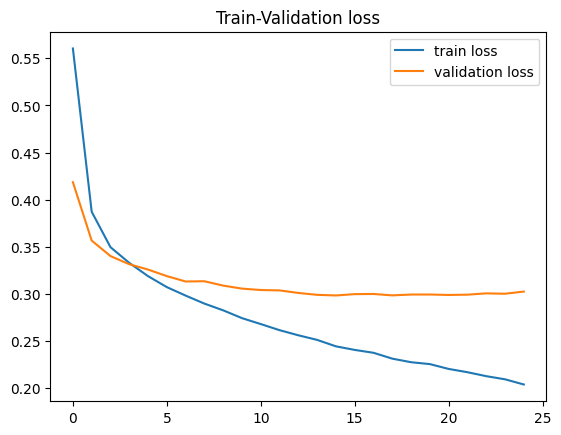

In [17]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_pos_about2'

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8405612244897959, 'precision': 0.8405612244897959, 'f1': 0.8405612244897959, 'accuracy': 0.8405612244897959}
MALE {'recall': 0.8411458333333334, 'precision': 0.8411458333333334, 'f1': 0.8411458333333333, 'accuracy': 0.8411458333333334}
FEMALE {'recall': 0.84, 'precision': 0.84, 'f1': 0.8399999999999999, 'accuracy': 0.84} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6641414141414141, 'precision': 0.6641414141414141, 'f1': 0.6641414141414141, 'accuracy': 0.6641414141414141}
MALE {'recall': 0.6909975669099757, 'precision': 0.6909975669099757, 'f1': 0.6909975669099757, 'accuracy': 0.6909975669099757}
FEMALE {'recall': 0.6351706036745407, 'precision': 0.6351706036745407, 'f1': 0.6351706036745407, 'accuracy': 0.6351706036745407} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6766623207301173, 'precision': 0.6766623207301173, 'f1': 0.6766623207301173, 'accuracy': 0.6766623207301173}
MALE {'rec

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5792912088516282 	 Validation loss: 0.4085695334410263 	 
  1%|          | 574/57400 [02:49<4:29:22,  3.52it/s]
Epoch 2 	 Training loss: 0.38373025919502207 	 Validation loss: 0.35743821728027475 	 
  2%|▏         | 1148/57400 [05:58<5:35:32,  2.79it/s]
Epoch 3 	 Training loss: 0.3505307977519384 	 Validation loss: 0.33913920743990755 	 
  3%|▎         | 1722/57400 [09:26<4:19:51,  3.57it/s]
Epoch 4 	 Training loss: 0.33236285452227976 	 Validation loss: 0.330426718723976 	 
  4%|▍         | 2296/57400 [12:37<3:35:21,  4.26it/s]
Epoch 5 	 Training loss: 0.31862427141089056 	 Validation loss: 0.32442438880265767 	 
  5%|▌         | 2870/57400 [15:26<3:44:40,  4.05it/s]
Epoch 6 	 Training loss: 0.3087863144351215 	 Validation loss: 0.318214616027929 	 
  6%|▌         | 3444/57400 [18:36<3:35:32,  4.17it/s]
Epoch 7 	 Training loss: 0.30010996504527765 	 Validation loss: 0.3144809295565395 	 
  7%|▋         | 4018/57400 [20:59<3:37:39,  4.09it/s]
Epoch 8 	 Traini

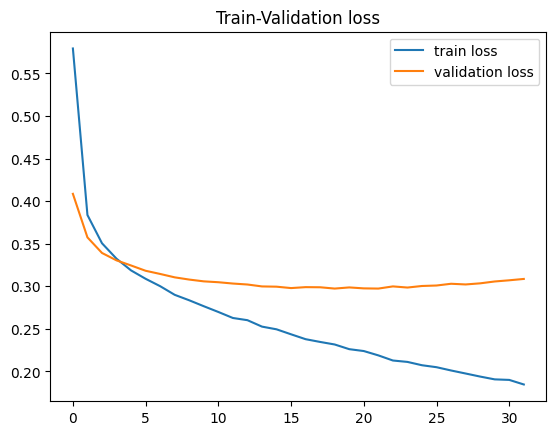

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_pos_about3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.8392857142857143, 'precision': 0.8392857142857143, 'f1': 0.8392857142857143, 'accuracy': 0.8392857142857143}
MALE {'recall': 0.8541666666666666, 'precision': 0.8541666666666666, 'f1': 0.8541666666666666, 'accuracy': 0.8541666666666666}
FEMALE {'recall': 0.825, 'precision': 0.825, 'f1': 0.825, 'accuracy': 0.825} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6565656565656566, 'precision': 0.6565656565656566, 'f1': 0.6565656565656566, 'accuracy': 0.6565656565656566}
MALE {'recall': 0.683698296836983, 'precision': 0.683698296836983, 'f1': 0.683698296836983, 'accuracy': 0.683698296836983}
FEMALE {'recall': 0.6272965879265092, 'precision': 0.6272965879265092, 'f1': 0.6272965879265092, 'accuracy': 0.6272965879265092} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6753585397653195, 'precision': 0.6753585397653195, 'f1': 0.6753585397653195, 'accuracy': 0.6753585397653195}
MALE {'recall': 0.671717

Resultados finales

In [21]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.8392857142857143, 'precision': 0.8392857142857143, 'f1': 0.8392857142857143, 'accuracy': 0.8392857142857143}
Métricas etiqueta male: {'recall': 0.8480902777777778, 'precision': 0.8480902777777778, 'f1': 0.8480902777777778, 'accuracy': 0.8480902777777778}
Métricas etiqueta female:  {'recall': 0.8308333333333333, 'precision': 0.8308333333333333, 'f1': 0.8308333333333333, 'accuracy': 0.8308333333333333}

 to
Resultado global: {'recall': 0.6628787878787878, 'precision': 0.6628787878787878, 'f1': 0.6628787878787878, 'accuracy': 0.6628787878787878}
Métricas etiqueta male: {'recall': 0.6861313868613139, 'precision': 0.6861313868613139, 'f1': 0.6861313868613139, 'accuracy': 0.6861313868613139}
Métricas etiqueta female:  {'recall': 0.6377952755905512, 'precision': 0.6377952755905512, 'f1': 0.6377952755905512, 'accuracy': 0.6377952755905512}

 as
Resultado global: {'recall': 0.6766623207301173, 'precision': 0.6766623207301173, 'f1': 0.6

# TO

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.694804378295194 	 Validation loss: 0.6934679453655824 	 
  1%|          | 574/57400 [02:23<3:44:33,  4.22it/s]
Epoch 2 	 Training loss: 0.6942415638252418 	 Validation loss: 0.6943560030500767 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:46<3:09:03,  4.96it/s]
Epoch 3 	 Training loss: 0.6936826502404562 	 Validation loss: 0.6931534621675136 	 
  3%|▎         | 1722/57400 [07:10<3:46:48,  4.09it/s]
Epoch 4 	 Training loss: 0.6935204133547141 	 Validation loss: 0.6927990004167719 	 
  4%|▍         | 2296/57400 [09:33<3:43:56,  4.10it/s]
Epoch 5 	 Training loss: 0.6931941660854459 	 Validation loss: 0.692665756758997 	 
  5%|▌         | 2870/57400 [11:57<3:44:46,  4.04it/s]
Epoch 6 	 Training loss: 0.6931029602833326 	 Validation loss: 0.6924597671476461 	 
  6%|▌         | 3444/57400 [14:20<3:38:55,  4.11it/s]
Epoch 7 	 Training loss: 0.6930008337472789 	 Validation loss: 0.693546306278746 	 

1 epoch without improvement
  7%|▋         | 4018

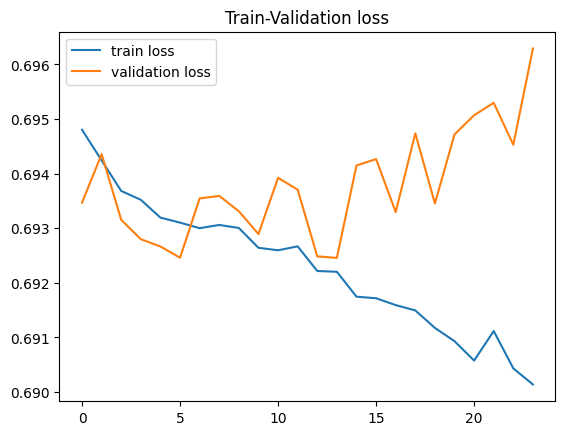

In [23]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_pos_to'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [17]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('distilbert_pos_to'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5369897959183674, 'precision': 0.5369897959183674, 'f1': 0.5369897959183674, 'accuracy': 0.5369897959183674}
MALE {'recall': 0.3411458333333333, 'precision': 0.3411458333333333, 'f1': 0.3411458333333333, 'accuracy': 0.3411458333333333}
FEMALE {'recall': 0.725, 'precision': 0.725, 'f1': 0.7250000000000001, 'accuracy': 0.725} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5454545454545454, 'precision': 0.5454545454545454, 'f1': 0.5454545454545454, 'accuracy': 0.5454545454545454}
MALE {'recall': 0.38929440389294406, 'precision': 0.38929440389294406, 'f1': 0.38929440389294406, 'accuracy': 0.38929440389294406}
FEMALE {'recall': 0.7139107611548556, 'precision': 0.7139107611548556, 'f1': 0.7139107611548556, 'accuracy': 0.7139107611548556} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5345501955671447, 'precision': 0.5345501955671447, 'f1': 0.5345501955671447, 'accuracy': 0.5345501955671447}
MAL

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6954185111182076 	 Validation loss: 0.692526302095187 	 
  1%|          | 574/57400 [02:54<4:30:12,  3.51it/s]
Epoch 2 	 Training loss: 0.6948428798843344 	 Validation loss: 0.6925939543772552 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [05:48<4:44:37,  3.29it/s]
Epoch 3 	 Training loss: 0.6945110145138531 	 Validation loss: 0.6928001500792422 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [08:52<4:14:42,  3.64it/s]
Epoch 4 	 Training loss: 0.6943924272309613 	 Validation loss: 0.693384951454098 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [12:08<4:12:50,  3.63it/s]
Epoch 5 	 Training loss: 0.6937808160790168 	 Validation loss: 0.6945934245141886 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [14:52<5:01:14,  3.02it/s]
Epoch 6 	 Training loss: 0.694132739658555 	 Validation loss: 0.6953000800084259 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [17:52<3:23:08,  4.43it/s]
Epoch 7 	 Training 

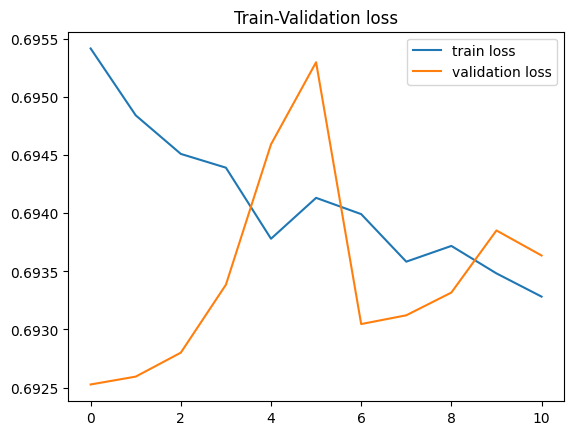

In [25]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_pos_to2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('distilbert_pos_to2'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5063775510204082, 'precision': 0.5063775510204082, 'f1': 0.5063775510204082, 'accuracy': 0.5063775510204082}
MALE {'recall': 0.15885416666666666, 'precision': 0.15885416666666666, 'f1': 0.15885416666666666, 'accuracy': 0.15885416666666666}
FEMALE {'recall': 0.84, 'precision': 0.84, 'f1': 0.8399999999999999, 'accuracy': 0.84} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4898989898989899, 'precision': 0.4898989898989899, 'f1': 0.4898989898989899, 'accuracy': 0.4898989898989899}
MALE {'recall': 0.18004866180048662, 'precision': 0.18004866180048662, 'f1': 0.18004866180048662, 'accuracy': 0.18004866180048662}
FEMALE {'recall': 0.8241469816272966, 'precision': 0.8241469816272966, 'f1': 0.8241469816272966, 'accuracy': 0.8241469816272966} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4667535853976532, 'precision': 0.4667535853976532, 'f1': 0.4667535853976532, 'accuracy': 0.4667535853976532}
MA

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6976529826062897 	 Validation loss: 0.6938793346033258 	 
  1%|          | 574/57400 [02:46<4:16:03,  3.70it/s]
Epoch 2 	 Training loss: 0.6941217674195559 	 Validation loss: 0.6925971407001301 	 
  2%|▏         | 1148/57400 [05:44<4:20:39,  3.60it/s]
Epoch 3 	 Training loss: 0.6939896664968351 	 Validation loss: 0.6941777194960642 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [08:27<4:24:02,  3.51it/s]
Epoch 4 	 Training loss: 0.6935247740471404 	 Validation loss: 0.6944754669221781 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [11:32<4:30:06,  3.40it/s]
Epoch 5 	 Training loss: 0.6935281653852828 	 Validation loss: 0.6937356601327153 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [14:54<5:12:17,  2.91it/s]
Epoch 6 	 Training loss: 0.6934107274128585 	 Validation loss: 0.6933384709439036 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [17:48<4:03:11,  3.70it/s]
Epoch 7 	 Training loss: 0.6935030687146071 	

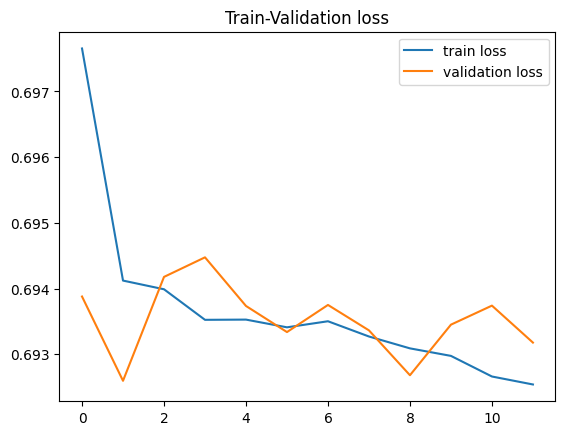

In [27]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_pos_to3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [19]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load('distilbert_pos_to3'))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5318877551020408, 'precision': 0.5318877551020408, 'f1': 0.5318877551020408, 'accuracy': 0.5318877551020408}
MALE {'recall': 0.171875, 'precision': 0.171875, 'f1': 0.171875, 'accuracy': 0.171875}
FEMALE {'recall': 0.8775, 'precision': 0.8775, 'f1': 0.8775, 'accuracy': 0.8775} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.51010101010101, 'precision': 0.51010101010101, 'f1': 0.51010101010101, 'accuracy': 0.51010101010101}
MALE {'recall': 0.15571776155717762, 'precision': 0.15571776155717762, 'f1': 0.15571776155717762, 'accuracy': 0.15571776155717762}
FEMALE {'recall': 0.8923884514435696, 'precision': 0.8923884514435696, 'f1': 0.8923884514435696, 'accuracy': 0.8923884514435696} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.49934810951760106, 'precision': 0.49934810951760106, 'f1': 0.49934810951760106, 'accuracy': 0.49934810951760106}
MALE {'recall': 0.12878787878787878, 'precision': 0.1287

Resultados finales

In [20]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5250850340136054, 'precision': 0.5250850340136054, 'f1': 0.5250850340136054, 'accuracy': 0.5250850340136054}
Métricas etiqueta male: {'recall': 0.22395833333333331, 'precision': 0.22395833333333331, 'f1': 0.22395833333333331, 'accuracy': 0.22395833333333331}
Métricas etiqueta female:  {'recall': 0.8141666666666666, 'precision': 0.8141666666666666, 'f1': 0.8141666666666666, 'accuracy': 0.8141666666666666}

 to
Resultado global: {'recall': 0.5151515151515151, 'precision': 0.5151515151515151, 'f1': 0.5151515151515151, 'accuracy': 0.5151515151515151}
Métricas etiqueta male: {'recall': 0.24168694241686944, 'precision': 0.24168694241686944, 'f1': 0.24168694241686944, 'accuracy': 0.24168694241686944}
Métricas etiqueta female:  {'recall': 0.8101487314085739, 'precision': 0.8101487314085739, 'f1': 0.8101487314085739, 'accuracy': 0.8101487314085739}

 as
Resultado global: {'recall': 0.5002172968274663, 'precision': 0.5002172968274663, '

# AS

In [21]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6953423264134636 	 Validation loss: 0.6930519938468933 	 
  1%|          | 574/57400 [02:39<3:27:05,  4.57it/s]
Epoch 2 	 Training loss: 0.6938349744791769 	 Validation loss: 0.6936256380404456 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [04:51<3:21:13,  4.66it/s]
Epoch 3 	 Training loss: 0.6921702420877662 	 Validation loss: 0.6920417789685525 	 
  3%|▎         | 1722/57400 [07:01<3:25:17,  4.52it/s]
Epoch 4 	 Training loss: 0.6909682294840597 	 Validation loss: 0.6915869773444483 	 
  4%|▍         | 2296/57400 [09:11<3:16:02,  4.68it/s]
Epoch 5 	 Training loss: 0.6895449907106805 	 Validation loss: 0.6918705621008145 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [11:20<2:48:37,  5.39it/s]
Epoch 6 	 Training loss: 0.6880340784891973 	 Validation loss: 0.6937803252268646 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [13:30<3:15:52,  4.59it/s]
Epoch 7 	 Training loss: 0.6874149158233549 	 Validation loss: 0.692552076

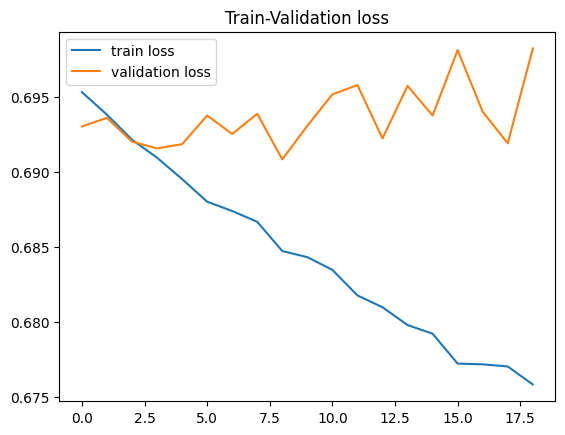

In [22]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_pos_as'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [23]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6135204081632653, 'precision': 0.6135204081632653, 'f1': 0.6135204081632653, 'accuracy': 0.6135204081632653}
MALE {'recall': 0.5859375, 'precision': 0.5859375, 'f1': 0.5859375, 'accuracy': 0.5859375}
FEMALE {'recall': 0.64, 'precision': 0.64, 'f1': 0.64, 'accuracy': 0.64} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6502525252525253, 'precision': 0.6502525252525253, 'f1': 0.6502525252525253, 'accuracy': 0.6502525252525253}
MALE {'recall': 0.6520681265206812, 'precision': 0.6520681265206812, 'f1': 0.6520681265206812, 'accuracy': 0.6520681265206812}
FEMALE {'recall': 0.6482939632545932, 'precision': 0.6482939632545932, 'f1': 0.6482939632545932, 'accuracy': 0.6482939632545932} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6623207301173403, 'precision': 0.6623207301173403, 'f1': 0.6623207301173403, 'accuracy': 0.6623207301173403}
MALE {'recall': 0.5782828282828283, 'precision': 0.578282828

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6948358219259707 	 Validation loss: 0.6924517225410979 	 
  1%|          | 574/57400 [02:09<2:53:00,  5.47it/s]
Epoch 2 	 Training loss: 0.6930071284754351 	 Validation loss: 0.6923971054917675 	 
  2%|▏         | 1148/57400 [04:19<3:15:34,  4.79it/s]
Epoch 3 	 Training loss: 0.6920164586774978 	 Validation loss: 0.6920361599679721 	 
  3%|▎         | 1722/57400 [06:24<3:22:08,  4.59it/s]
Epoch 4 	 Training loss: 0.6905064141501117 	 Validation loss: 0.6904670050588705 	 
  4%|▍         | 2296/57400 [08:30<3:20:19,  4.58it/s]
Epoch 5 	 Training loss: 0.6888792512724209 	 Validation loss: 0.6929413474212258 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [10:35<3:13:54,  4.69it/s]
Epoch 6 	 Training loss: 0.6879308683739307 	 Validation loss: 0.6899713146484504 	 
  6%|▌         | 3444/57400 [12:41<3:08:59,  4.76it/s]
Epoch 7 	 Training loss: 0.6872365111257972 	 Validation loss: 0.6917422939155061 	 

1 epoch without improvement
  7%|▋         | 4

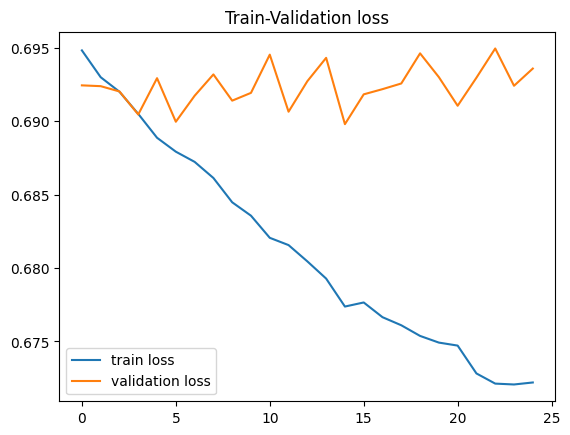

In [24]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_pos_as2'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [25]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6262755102040817, 'precision': 0.6262755102040817, 'f1': 0.6262755102040817, 'accuracy': 0.6262755102040817}
MALE {'recall': 0.5911458333333334, 'precision': 0.5911458333333334, 'f1': 0.5911458333333334, 'accuracy': 0.5911458333333334}
FEMALE {'recall': 0.66, 'precision': 0.66, 'f1': 0.66, 'accuracy': 0.66} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6553030303030303, 'precision': 0.6553030303030303, 'f1': 0.6553030303030303, 'accuracy': 0.6553030303030303}
MALE {'recall': 0.6204379562043796, 'precision': 0.6204379562043796, 'f1': 0.6204379562043796, 'accuracy': 0.6204379562043796}
FEMALE {'recall': 0.6929133858267716, 'precision': 0.6929133858267716, 'f1': 0.6929133858267716, 'accuracy': 0.6929133858267716} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.6792698826597132, 'precision': 0.6792698826597132, 'f1': 0.6792698826597132, 'accuracy': 0.6792698826597132}
MALE {'recall': 0.590909

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6939943612452584 	 Validation loss: 0.6926360382872113 	 
  1%|          | 574/57400 [02:05<3:35:54,  4.39it/s]
Epoch 2 	 Training loss: 0.6925383231988768 	 Validation loss: 0.6916220289165691 	 
  2%|▏         | 1148/57400 [04:11<2:43:28,  5.74it/s]
Epoch 3 	 Training loss: 0.6915059973346231 	 Validation loss: 0.6907349137936608 	 
  3%|▎         | 1722/57400 [06:16<3:13:03,  4.81it/s]
Epoch 4 	 Training loss: 0.6892037900482736 	 Validation loss: 0.6900115760706239 	 
  4%|▍         | 2296/57400 [08:21<3:22:17,  4.54it/s]
Epoch 5 	 Training loss: 0.6877838082429839 	 Validation loss: 0.6938935144472931 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [10:26<3:05:28,  4.90it/s]
Epoch 6 	 Training loss: 0.686250078657363 	 Validation loss: 0.6930127830828651 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [12:31<3:18:42,  4.53it/s]
Epoch 7 	 Training loss: 0.6845759311204173 	 Validation loss: 0.6900255023422888 	 

3 epoch without im

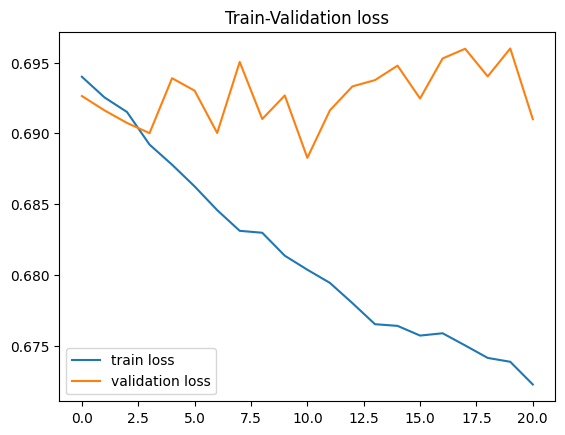

In [26]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='distilbert_pos_as3'
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [27]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.6658163265306123, 'precision': 0.6658163265306123, 'f1': 0.6658163265306123, 'accuracy': 0.6658163265306123}
MALE {'recall': 0.6197916666666666, 'precision': 0.6197916666666666, 'f1': 0.6197916666666666, 'accuracy': 0.6197916666666666}
FEMALE {'recall': 0.71, 'precision': 0.71, 'f1': 0.7100000000000001, 'accuracy': 0.71} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.6616161616161617, 'precision': 0.6616161616161617, 'f1': 0.6616161616161617, 'accuracy': 0.6616161616161617}
MALE {'recall': 0.6472019464720195, 'precision': 0.6472019464720195, 'f1': 0.6472019464720195, 'accuracy': 0.6472019464720195}
FEMALE {'recall': 0.6771653543307087, 'precision': 0.6771653543307087, 'f1': 0.6771653543307087, 'accuracy': 0.6771653543307087} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.7079530638852672, 'precision': 0.7079530638852672, 'f1': 0.7079530638852672, 'accuracy': 0.7079530638852672}
MALE {'rec

Resultados finales

In [28]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.6352040816326531, 'precision': 0.6352040816326531, 'f1': 0.6352040816326531, 'accuracy': 0.6352040816326531}
Métricas etiqueta male: {'recall': 0.5989583333333334, 'precision': 0.5989583333333334, 'f1': 0.5989583333333334, 'accuracy': 0.5989583333333334}
Métricas etiqueta female:  {'recall': 0.67, 'precision': 0.67, 'f1': 0.67, 'accuracy': 0.67}

 to
Resultado global: {'recall': 0.6557239057239057, 'precision': 0.6557239057239057, 'f1': 0.6557239057239057, 'accuracy': 0.6557239057239057}
Métricas etiqueta male: {'recall': 0.6399026763990268, 'precision': 0.6399026763990268, 'f1': 0.6399026763990268, 'accuracy': 0.6399026763990268}
Métricas etiqueta female:  {'recall': 0.6727909011373578, 'precision': 0.6727909011373578, 'f1': 0.6727909011373578, 'accuracy': 0.6727909011373578}

 as
Resultado global: {'recall': 0.6831812255541069, 'precision': 0.6831812255541069, 'f1': 0.6831812255541069, 'accuracy': 0.6831812255541069}
Métrica